<a href="https://colab.research.google.com/github/vamshigaddi/Assignments/blob/main/Video_Classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip /content/drive/MyDrive/TASK_1.zip -d /content/drive/MyDrive/TASK_1

Archive:  /content/drive/MyDrive/TASK_1.zip
   creating: /content/drive/MyDrive/TASK_1/TASK1 - Copy/ApplyEyeMakeup/
  inflating: /content/drive/MyDrive/TASK_1/TASK1 - Copy/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi  
  inflating: /content/drive/MyDrive/TASK_1/TASK1 - Copy/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.avi  
  inflating: /content/drive/MyDrive/TASK_1/TASK1 - Copy/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c03.avi  
  inflating: /content/drive/MyDrive/TASK_1/TASK1 - Copy/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c04.avi  
  inflating: /content/drive/MyDrive/TASK_1/TASK1 - Copy/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c05.avi  
  inflating: /content/drive/MyDrive/TASK_1/TASK1 - Copy/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c06.avi  
  inflating: /content/drive/MyDrive/TASK_1/TASK1 - Copy/ApplyEyeMakeup/v_ApplyEyeMakeup_g02_c01.avi  
  inflating: /content/drive/MyDrive/TASK_1/TASK1 - Copy/ApplyEyeMakeup/v_ApplyEyeMakeup_g02_c02.avi  
  inflating: /content/drive/MyDrive/TASK_1/TASK1 - Copy/ApplyEyeMake

## **Reading the Frames and Labels from the videos**

In [3]:
import os
import cv2
import numpy as np

# Define the path to the main folder containing category folders
main_folder = '/content/drive/MyDrive/TASK_1/TASK1 - Copy'

# List category folders
categories = os.listdir(main_folder)

# Initialize lists to store video frames and corresponding labels
frames = []
labels = []

# Frame subsampling interval
interval = 10  # Adjust this interval as needed

# Function to read frames from a video file with frame subsampling
def read_frames(video_path, interval):
    video_frames = []
    video_capture = cv2.VideoCapture(video_path)
    frame_count = 0
    while True:
        ret, frame = video_capture.read()
        if not ret:
            break
        if frame_count % interval == 0:
            # Preprocess the frame (e.g., resize, normalize) if necessary
            # For example, you can resize the frame to a fixed size
            frame = cv2.resize(frame, (224, 224))  # Assuming the frame size is (224, 224)

            # Convert the frame to RGB format (OpenCV reads frames in BGR format)
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            #frame_normalized = frame_rgb / 255.0

            # Append the preprocessed frame to the video_frames list
            video_frames.append(frame_rgb)
        frame_count += 1
    video_capture.release()
    return video_frames

# Loop through each category folder
for category in categories:
    category_folder = os.path.join(main_folder, category)

    # Get the list of video files in the category folder
    video_files = [f for f in os.listdir(category_folder) if f.endswith(".mp4") or f.endswith(".avi")]

    # Assign a label to each category
    label = categories.index(category)

    # Loop through each video file in the category folder
    for video_file in video_files:
        video_path = os.path.join(category_folder, video_file)

        # Read frames from the video file with frame subsampling
        video_frames = read_frames(video_path, interval)

        # Append the video_frames and label to the frames and labels lists
        frames.extend(video_frames)
        labels.extend([label] * len(video_frames))

# Convert frames and labels to NumPy arrays
frames = np.array(frames)
labels = np.array(labels)

# Print the shape of frames and labels
print("Shape of frames:", frames.shape)
print("Shape of labels:", labels.shape)


Shape of frames: (9796, 224, 224, 3)
Shape of labels: (9796,)


**Class_names of the vidoes**

In [6]:
class_names=['ApplyEyeMakeup', 'Person sitting on a chair', 'Person walking away from chair', 'PlayingMusic', 'Sports']

In [7]:
unique_values, counts = np.unique(labels, return_counts=True)

# Print unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0, Count: 2495
Value: 1, Count: 881
Value: 2, Count: 513
Value: 3, Count: 3995
Value: 4, Count: 1912


# **Train test split**

In [8]:
# Split dataset
from sklearn.model_selection import train_test_split
train_features, val_features, train_targets, val_targets = train_test_split(frames, labels, test_size=0.2, random_state=42)

# **Preparing My Train and valid dataset**

In [9]:
import tensorflow as tf

# Define batch size
batch_size = 8  # Reduce batch size

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_targets)).shuffle(batch_size * 4).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)  # Reduce prefetch buffer size

valid_ds = tf.data.Dataset.from_tensor_slices((val_features, val_targets)).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)  # Reduce prefetch buffer size


# **clean up memory**

In [10]:
del train_features
del val_features


In [11]:
# Display shape of a batch
for X, y in train_ds.take(1):
    print(X.shape, y.shape)

(8, 224, 224, 3) (8,)


## **Loading Pretrained model**

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

num_classes=5
# Load pre-trained ResNet50 model (without top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Dense(1024, activation='relu')(x)  # Dense hidden layer with ReLU activation
predictions = Dense(num_classes, activation='softmax')(x)  # Output layer for classification

# Combine base model and top layers to create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                         

In [13]:
# Train model
history = model.fit(
    train_ds,
    epochs=5,
    validation_data=valid_ds,
    #callbacks=[
        #tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        #tf.keras.callbacks.ModelCheckpoint(
            #"efficient_net_model.h5",
           # monitor="val_accuracy",
           # mode="max",
        #)
    #]##
)

Epoch 1/5
980/980 [==============================] - 44s 38ms/step - loss: 0.0676 - accuracy: 0.9866 - val_loss: 1.5863e-05 - val_accuracy: 1.0000
Epoch 2/5
980/980 [==============================] - 36s 36ms/step - loss: 0.0104 - accuracy: 0.9977 - val_loss: 0.1487 - val_accuracy: 0.9827
Epoch 3/5
980/980 [==============================] - 37s 38ms/step - loss: 0.0230 - accuracy: 0.9968 - val_loss: 0.0051 - val_accuracy: 0.9995
Epoch 4/5
980/980 [==============================] - 40s 41ms/step - loss: 0.0096 - accuracy: 0.9987 - val_loss: 7.9644e-05 - val_accuracy: 1.0000
Epoch 5/5
980/980 [==============================] - 36s 37ms/step - loss: 0.0022 - accuracy: 0.9996 - val_loss: 2.1530e-08 - val_accuracy: 1.0000


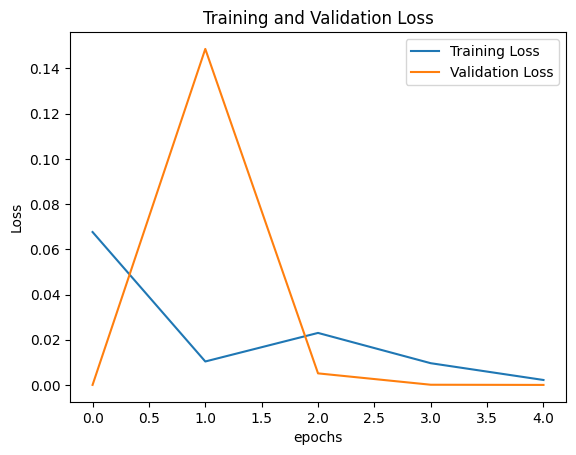

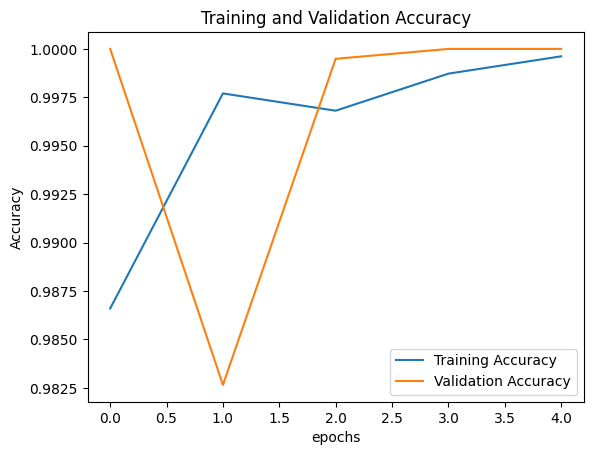

In [35]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Making inference on the frame**

1/1 [==============================] - 0s 27ms/step
Actual Label: ApplyEyeMakeup
Predicted Label: ApplyEyeMakeup


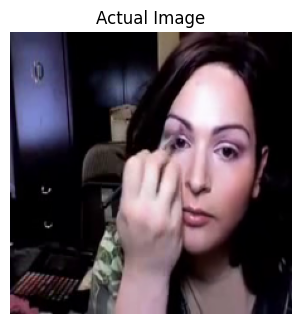

In [15]:
import matplotlib.pyplot as plt

# Take one image and its label from the validation dataset
for image, label in valid_ds.take(1):
    # Make predictions on the image using the trained model
    predictions = model.predict(image)

    # Get the predicted class (index with highest probability)
    predicted_class_index = tf.argmax(predictions[0]).numpy()

    # Get the actual class index and corresponding label
    actual_class_index = label[0].numpy()
    actual_class_label = class_names[actual_class_index]

    # Get the predicted class label
    predicted_class_label = class_names[predicted_class_index]

    # Display the actual label and predicted label
    print("Actual Label:", actual_class_label)
    print("Predicted Label:", predicted_class_label)

    # Display the actual image
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(image[0].numpy().astype("uint8"))  # Convert to uint8 for proper display
    plt.title("Actual Image")
    plt.axis('off')  # Turn off axis


# **Making inference on the video**

In [31]:
from IPython.display import display, HTML

# Load the video and preprocess frames
video_path = '/content/drive/MyDrive/TASK_1/TASK1 - Copy/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi'
frame_interval = 10  # Set the interval for frame subsampling
video_frames = read_frames(video_path, frame_interval)


# Get the actual class name (based on the predicted class index)
actual_class_name = os.path.basename(os.path.dirname(video_path))

# Make predictions on each frame
predictions = []
for frame in video_frames:
    # Preprocess the frame if necessary (already preprocessed in read_frames function)
    # Make predictions on the preprocessed frame
    prediction = model.predict(np.expand_dims(frame, axis=0))
    predictions.append(prediction)

# Aggregate predictions (e.g., averaging)
aggregated_prediction = np.mean(predictions, axis=0)

# Get the predicted class index
predicted_class_index = np.argmax(aggregated_prediction)



# Get the predicted class name
predicted_class_name = class_names[predicted_class_index]

# Display the video
display(HTML("""<video width="320" height="240" controls>
                 <source src="{0}" type="video/mp4">
                 </video>""".format(video_path)))

# Print the actual and predicted labels
print("Actual Label:", actual_class_name)
print("Predicted Label:", predicted_class_name)


1/1 [==============================] - 0s 22ms/step


Actual Label: ApplyEyeMakeup
Predicted Label: ApplyEyeMakeup


In [30]:
video_path = '/content/drive/MyDrive/TASK_1/TASK1 - Copy/Person walking away from chair/Person_walking awat from chair_09.mp4'
os.path.basename(os.path.dirname(video_path))

'Person walking away from chair'

In [32]:
from IPython.display import display, HTML

# Load the video and preprocess frames
video_path = '/content/drive/MyDrive/TASK_1/TASK1 - Copy/Person walking away from chair/Person_walking awat from chair_09.mp4'
frame_interval = 10  # Set the interval for frame subsampling
video_frames = read_frames(video_path, frame_interval)

actual_class_name = os.path.basename(os.path.dirname(video_path))
# Make predictions on each frame
predictions = []
for frame in video_frames:
    # Preprocess the frame if necessary (already preprocessed in read_frames function)
    # Make predictions on the preprocessed frame
    prediction = model.predict(np.expand_dims(frame, axis=0))
    predictions.append(prediction)

# Aggregate predictions (e.g., averaging)
aggregated_prediction = np.mean(predictions, axis=0)

# Get the predicted class index
predicted_class_index = np.argmax(aggregated_prediction)


# Get the predicted class name
predicted_class_name = class_names[predicted_class_index]

# Display the video
display(HTML("""<video width="320" height="240" controls>
                 <source src="{0}" type="video/mp4">
                 </video>""".format(video_path)))

# Print the actual and predicted labels
print("Actual Label:", actual_class_name)
print("Predicted Label:", predicted_class_name)


1/1 [==============================] - 0s 40ms/step


Actual Label: Person walking away from chair
Predicted Label: Person walking away from chair


In [33]:
from IPython.display import display, HTML

# Load the video and preprocess frames
video_path = '/content/drive/MyDrive/TASK_1/TASK1 - Copy/Sports/v_Basketball_g01_c01.avi'
frame_interval = 10  # Set the interval for frame subsampling
video_frames = read_frames(video_path, frame_interval)

actual_class_name = os.path.basename(os.path.dirname(video_path))
# Make predictions on each frame
predictions = []
for frame in video_frames:
    # Preprocess the frame if necessary (already preprocessed in read_frames function)
    # Make predictions on the preprocessed frame
    prediction = model.predict(np.expand_dims(frame, axis=0))
    predictions.append(prediction)

# Aggregate predictions (e.g., averaging)
aggregated_prediction = np.mean(predictions, axis=0)

# Get the predicted class index
predicted_class_index = np.argmax(aggregated_prediction)


# Get the predicted class name
predicted_class_name = class_names[predicted_class_index]

# Display the video
display(HTML("""<video width="320" height="240" controls>
                 <source src="{0}" type="video/mp4">
                 </video>""".format(video_path)))

# Print the actual and predicted labels
print("Actual Label:", actual_class_name)
print("Predicted Label:", predicted_class_name)


1/1 [==============================] - 0s 21ms/step


Actual Label: Sports
Predicted Label: Sports


In [19]:
from IPython.display import HTML, display

def display_avi_video(file_path):
    # Convert AVI video to MP4 format
    mp4_file_path = file_path[:-3] + 'mp4'
    !ffmpeg -i "{file_path}" -c:v libx264 -crf 23 -c:a aac -q:a 100 -y "{mp4_file_path}"

    # Define the HTML video tag with the source set to the MP4 file path
    video_html = f"""
    <video width="640" height="480" controls>
        <source src="{mp4_file_path}" type="video/mp4">
        Your browser does not support the video tag.
    </video>
    """

    # Display the HTML video tag
    display(HTML(video_html))

# Example usage: display an AVI video file
avi_video_path = '/content/drive/MyDrive/TASK_1/TASK1 - Copy/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi'
display_avi_video(avi_video_path)


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [27]:
import os

video_path = '/content/drive/MyDrive/TASK_1/TASK1 - Copy/Person sitting on a chair/pexels-anastasia-shuraeva-7540248 (720p) (1).mp4'

# Extract class name from the folder containing the video file
os.path.basename(os.path.dirname(video_path))



'Person sitting on a chair'